Un regroupement des caractéristiques obtenues est effectué sur une collection d'images définie par (n1,n2).
La collection d'images utilisée est "aloi_red4_view" (72 images per object)  
L'algorithme du clustering est le k-means avec une distance euclidienne.
Les résultats sont évalués à l'aide de métriques comme l'adjusted rand score.

Number of images= 1440
Number of features= 179




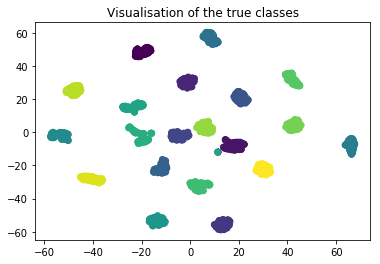

**************Clustering_results*********************
Number of clusters= 20
adjusted_rand_score=0.74
homogeneity_score=0.90
completeness_score=0.95
v_measure_score=0.92
fowlkes_mallows_score=0.76




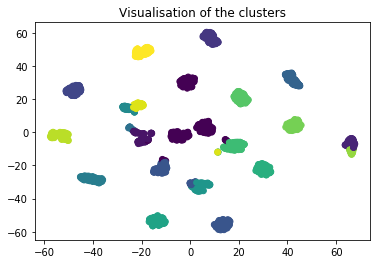

**************Clustering_results_after_TSNE*********************
Number of clusters= 20
adjusted_rand_score=1.00
homogeneity_score=1.00
completeness_score=1.00
v_measure_score=1.00
fowlkes_mallows_score=1.00




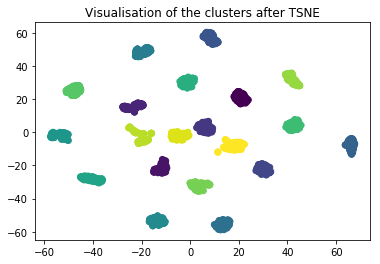

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from Image_reading import *
from Color_descriptors import *
from Shape_descriptors import fft_shape
from Texture_descriptors import lbp

from Clustering import clustering_kmeans




if __name__ == '__main__':
#   Parameters defintion:
    n1=1 # First image (included)
    n2=21 # Last image (excluded)
    n_img=72
    n_clusters_=n2-n1 # number of objects
    color_space='hsv'
    bins=[4,4,4]
    n_colors=8
    n_fft=64
    hist_size_lbp=100
    
    classes_true=[]
    for i in range(0,n2-n1):
        classes_true=classes_true+[i]*n_img
    classes_true=np.array(classes_true)

#     First, we regroup the images features in a single 2D-Array where each line is the feature vector of the image
    X_all=[]
    for i in range(n_img*(n2-n1)):
        X_all.append([])
    for i in range(n2-n1):
        for j in range(n_img):
            X=read_image_2(i+n1,j)
            # ********************Color_features***********************
            moments_ftr=moments_calcul(X,color_space)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[moments_ftr]
            
            hist= color_histogram(X,color_space,bins)
            # hist=histogram_filter(hist)
            # hist=histogram_normalization(hist)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[hist]
            
            """
            # ********************Shape_features***********************
            shape_fft=fft_shape(X,n_fft)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[shape_fft]
            
            """
            # ********************Texture_features***********************
            lbp_feature=lbp(X,hist_size_lbp)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[lbp_feature]
            
            
            
            X_all[n_img*i+j]=np.concatenate(X_all[n_img*i+j])
    
    X_all=np.array(X_all).astype(float)
    print("Number of images= "+ str(X_all.shape[0]))
    print("Number of features= "+ str(X_all.shape[1]))
    print("\n")
    
    
    # ************Visualisation_before_clustering******************
    
    X_norm = StandardScaler().fit_transform(X_all)
    X_embedded = TSNE(n_components=2).fit_transform(X_norm)
    
    plt.figure()
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes_true)
    plt.title("Visualisation of the true classes")
    plt.show()

    

    # ********************Clustering************************
    classes=clustering_kmeans(X_all,n_clusters_)
    
    
    print("**************Clustering_results*********************")
    print("Number of clusters= "+str(max(classes)+1))
    print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
    # print('normalized_mutual_info_score=%0.2f' % metrics.normalized_mutual_info_score(classes_true,classes))
    print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
    print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
    print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
    print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))
    print("\n")
    
    # ************Visualisation_after_clustering******************
    plt.figure()
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes)
    plt.title("Visualisation of the clusters")
    plt.show()
    
    
    
    # ********************Clustering_after_TSNE************************
    classes_embedded=clustering_kmeans(X_embedded,n_clusters_)
    
    
    print("**************Clustering_results_after_TSNE*********************")
    print("Number of clusters= "+str(max(classes_embedded)+1))
    print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes_embedded))
    # print('normalized_mutual_info_score=%0.2f' % metrics.normalized_mutual_info_score(classes_true,classes_embedded))
    print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes_embedded))
    print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes_embedded))
    print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes_embedded))
    print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes_embedded))
    print("\n")
    
    # ************Visualisation_after_TSNE******************
    plt.figure()
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes_embedded)
    plt.title("Visualisation of the clusters after TSNE")
    plt.show()
